In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

#                   Introduction
In Natural Language Processing (NLP) the conversion of raw-text to numerical form is called **Text Representation** and believe me this step is one of the most important steps in the NLP pipeline as if we feed in poor features in ML Model, we will get poor results. In computer science, this is often called “garbage in, garbage out.”


**I observed in NLP feeding a good text representation to an ordinary algorithm will get you much farther compared to applying a topnotch algorithm to an ordinary text representation.**



In this notebook, I will discuss various text-representation schemes with their advantages and disadvantages so that you can choose one of the schemes which suit your task most. Our main objective is to transform a given text into numerical form so that it can be fed into NLP and ML algorithms.

# Load a Clean Dataset

Kaggle Datasets is one of the best sources to get a clean dataset for this notebook I will be using Twitter US Airline Sentiment dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clean_data = pd.read_csv('/content/drive/MyDrive/Tweets.csv')


In [ ]:
clean_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

<Axes: xlabel='airline_sentiment', ylabel='count'>

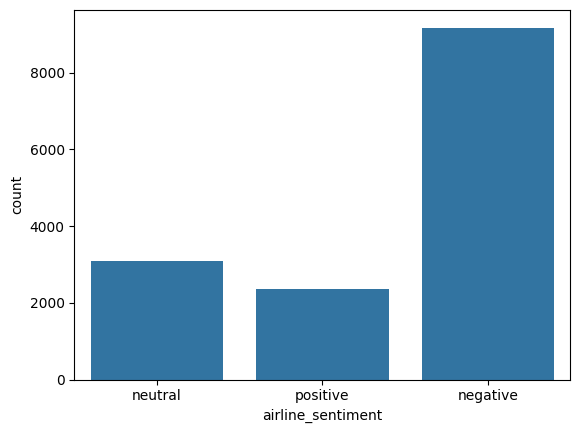

In [ ]:
sns.countplot(x= "airline_sentiment", data = clean_data)

# Basic Text Pre-Processing
Text preprocessing steps include a few essential tasks to further clean the available text data. It includes tasks like:-

**1. Stop-Word Removal :** In English words like a, an, the, as, in, on, etc. are considered as stop-words so according to our requirements we can remove them to reduce vocabulary size as these words don't have some specific meaning

**2. Lower Casing :** Convert all words into the lower case because the upper or lower case may not make a difference for the problem. And we are reducing vocabulary size by doing so.

**3. Stemming :** Stemming refers to the process of removing suffixes and reducing a word to some base form such that all different variants of that word can be represented by the same form (e.g., “walk” and “walking” are both reduced to “walk”).

**4. Tokenization :** NLP software typically analyzes text by breaking it up into words (tokens) and sentences.

Pre-processing of the text is not the main objective of this notebook that's why I am just covering a few basic steps in a brief

In [ ]:
# First of all let's drop the columns which we don't required

waste_col = ['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone']

data = clean_data.drop(waste_col, axis = 1)

In [ ]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
def sentiment(x):
  if x == 'positive':
    return 1
  elif x == 'negative':
    return -1
  else:
    return 0

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')
# As this dataset is fetched from twitter so it has lots of people tag in tweets
# we will remove them
tags = r"@\w*"


def preprocess_text(sentence, stem = False):

    sentence = [re.sub(tags, "", sentence)]
    text = []
    for word in sentence:

        if word not in stopwords:

            if stem:
                text.append(stemmer.stem(word).lower())
            else:
                text.append(word.lower())
    return tokenizer.tokenize(" ".join(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(f"Orignal Text : {data.text[11]}")
print()
print(f"Preprocessed Text : {preprocess_text(data.text[11])}")

Orignal Text : @VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D

Preprocessed Text : ['i', 'lt', '3', 'pretty', 'graphics', 'so', 'much', 'better', 'than', 'minimal', 'iconography', 'd']


# Bag of words
Bag of words (BoW) is a classical text representation technique that has been used commonly in NLP, especially in text classification problems. The key idea behind it is as follows: represent the text under consideration as a bag (collection) of words while ignoring the order and context.

**let say we have a vocabulary V consisting of words --> {the, cat, sat, in, hat, with} then the bag of word representation of a few sentences will be given as**

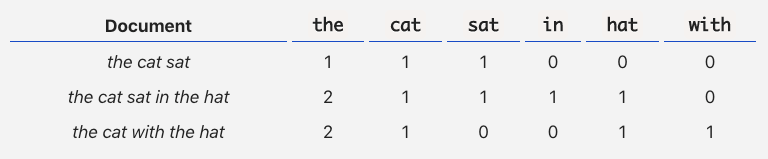


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

sample_bow = CountVectorizer()

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_bow.fit(sample_corpus)

def get_bow_representation(text):
        return sample_bow.transform(text)

print(f"Vocabulary mapping for given sample corpus : \n {sample_bow.vocabulary_}")
print("\nBag of word Representation of sentence 'the cat sat in the hat'")
print(get_bow_representation(["the cat sat in the hat"]).toarray())

Vocabulary mapping for given sample corpus : 
 {'the': 4, 'cat': 0, 'sat': 3, 'in': 2, 'hat': 1, 'with': 5}

Bag of word Representation of sentence 'the cat sat in the hat'
[[1 1 1 1 2 0]]


In [ ]:
# generate bag of word representation for given dataset

bow = CountVectorizer()
bow_rep = bow.fit_transform(data.loc[:, 'text'].astype('str'))

In [ ]:
print(f"Shape of Bag of word representaion matrix : {bow_rep.toarray().shape}")


Shape of Bag of word representaion matrix : (14640, 15051)


# TF-IDF
In all the three approaches we’ve seen so far, all the words in the text are treated as equally important—there’s no notion of some words in the document being more important than others. TF-IDF, or term frequency-inverse document frequency, addresses this issue. It aims to quantify the importance of a given word relative to other words in the document and in the corpus.


The intuition behind TF-IDF is as follows: if a word w appears many times in a sentence S1 but does not occur much in the rest of the Sentences Sn in the corpus, then the word w must be of great importance to the Sentence S1. The importance of w should increase in proportion to its frequency in S1 (how many times that word occurs in sentence S1), but at the same time, its importance should decrease in proportion to the word’s frequency in other Sentence Sn in the corpus. Mathematically, this is captured using two quantities: TF and IDF. The two are then multiplied to arrive at the TF-IDF score.

# TF (term frequency) measures how often a term or word occurs in a given document.

**Mathematical Expression of TF**

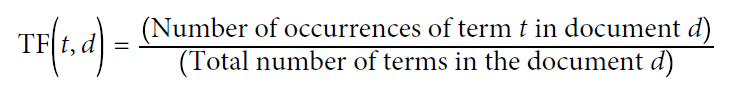

# IDF (inverse document frequency) measures the importance of the term across a corpus.

 In computing TF, all terms are given equal importance (weightage). However, it’s a well-known fact that stop words like is, are, am, etc., are not important, even though they occur frequently. To account for such cases, IDF weighs down the terms that are very common across a corpus and weighs up the rare terms.

 **IDF of a term t is calculated as follows:**

 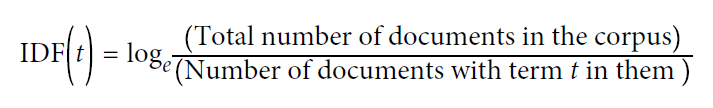

 The TF-IDF score is a product of these two terms. Thus, TF-IDF score = TF * IDF. Let’s consider an example.

Sentence A = The Car is Driven on the Road

Sentence B = The Truck is Driven on the highway

**Computation of TF-IDF scores are shown below**

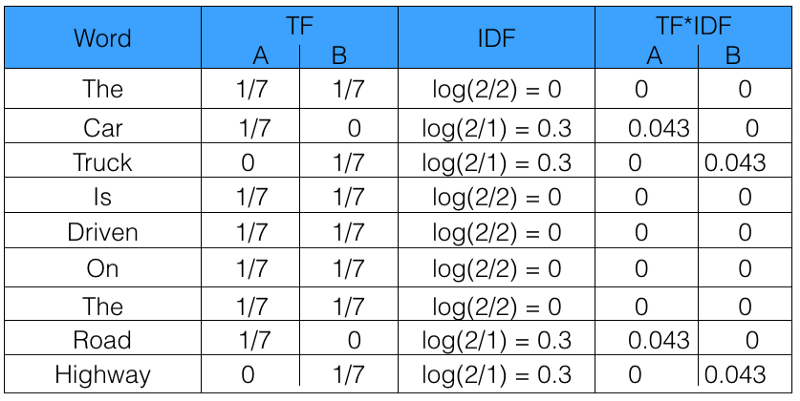

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]
tfidf_rep = tfidf.fit_transform(sample_corpus)
print(f"IDF Values for sample corpus : {tfidf.idf_}")


print("TF-IDF Representation for sentence 'the cat sat in the hat' :")
print(tfidf.transform(["the cat sat in the hat"]).toarray())

IDF Values for sample corpus : [1.         1.28768207 1.69314718 1.28768207 1.         1.69314718]
TF-IDF Representation for sentence 'the cat sat in the hat' :
[[0.29903422 0.385061   0.50630894 0.385061   0.59806843 0.        ]]


# Word2vec Word Embeddings
**Word Embeddings :** They are a real-valued vector representation of words that allows words with the same meaning to have similar representation. Thus we can say word embeddings are the projection of meanings of words in a real-valued vector

Word2vec is a Word Embedding Technique published in 2013. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text.

It is the representation of words that allows words with the same meaning to have similar representation, Word2vec operationalizes this by projecting the meaning of the words in a vector space where words with similar meanings will tend to cluster together, and works with very different meanings are far from one another.

In [ ]:
# Install gensim library if not already installed​
# pip install gensim​
import nltk
nltk.download('punkt')
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Create sample documents​
documents = ["This is the first document.",
"This document is the second document.",
"And this is the third one."
]

# Tokenize the documents​
tokenized_documents = [word_tokenize(doc.lower()) for doc in documents]

# Train Word2Vec model​
model = Word2Vec(sentences = tokenized_documents, vector_size=100, window=5, min_count=1, workers=4)

# Example: Get vector representation for the word 'document'
vector_representation = model.wv['document']
print("Vector Representation for 'document':", vector_representation)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Vector Representation for 'document': [-8.6204959e-03  3.6656798e-03  5.1890435e-03  5.7413341e-03
  7.4667106e-03 -6.1669527e-03  1.1071442e-03  6.0478016e-03
 -2.8417453e-03 -6.1734831e-03 -4.1064565e-04 -8.3685964e-03
 -5.6015723e-03  7.1051149e-03  3.3512993e-03  7.2244625e-03
  6.8005081e-03  7.5318469e-03 -3.7887152e-03 -5.6384038e-04
  2.3478975e-03 -4.5202258e-03  8.3918469e-03 -9.8565696e-03
  6.7639211e-03  2.9146592e-03 -4.9328543e-03  4.3973904e-03
 -1.7405687e-03  6.7118029e-03  9.9671669e-03 -4.3619340e-03
 -5.9958611e-04 -5.6970902e-03  3.8511248e-03  2.7869588e-03
  6.8903468e-03  6.1010849e-03  9.5382044e-03  9.2721898e-03
  7.9001701e-03 -6.9917394e-03 -9.1567943e-03 -3.5570699e-04
 -3.0986702e-03  7.8943772e-03  5.9379833e-03 -1.5462040e-03
  1.5110098e-03  1.7886526e-03  7.8182593e-03 -9.5115863e-03
 -2.0458201e-04  3.4695806e-03 -9.4097451e-04  8.3801365e-03
  9.0101836e-03  6.5338048e-03 -7.1310432e-04  7.7079539e-03
 -8.5331853e-03  3.2056449e-03 -4.6360181e-03 -